In [41]:
import kagglehub
gaborfodor_keras_pretrained_models_path = kagglehub.dataset_download('gaborfodor/keras-pretrained-models')
navoneel_brain_mri_images_for_brain_tumor_detection_path = kagglehub.dataset_download('navoneel/brain-mri-images-for-brain-tumor-detection')

print('Data source import complete.')


  9%|▉         | 85.0M/943M [00:04<00:48, 18.7MB/s]


KeyboardInterrupt: 

In [ ]:
import os
import shutil

brain_mri_path = "/root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1"
keras_models_path = "/root/.cache/kagglehub/datasets/gaborfodor/keras-pretrained-models/versions/11"

print("Brain MRI dataset files:", os.listdir(brain_mri_path) if os.path.exists(brain_mri_path) else "Path not found")
print("Keras pretrained models files:", os.listdir(keras_models_path) if os.path.exists(keras_models_path) else "Path not found")



# Define source and destination paths
destination_dir = "./data"  # Change to your preferred directory

# Move Brain MRI dataset
shutil.move("/root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1", destination_dir + "/brain_mri")

# Move Keras pretrained models
shutil.move("/root/.cache/kagglehub/datasets/gaborfodor/keras-pretrained-models/versions/11", destination_dir + "/keras_models")

print("Files moved successfully!")

# <a id='intro'>1. Project Overview and Objectives</a>

The main purpose of this project was to build a CNN model that would classify if subject has a tumor or not base on MRI scan. I used the [VGG-16](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection) model architecture and weights to train the model for this binary problem. I used `accuracy` as a metric to justify the model performance which can be defined as:

$\textrm{Accuracy} = \frac{\textrm{Number of correclty predicted images}}{\textrm{Total number of tested images}} \times 100\%$

Final results look as follows:

| Set | Accuracy |
|:-:|:-:|
| Validation Set* | ~88% |
| Test Set* | ~80% |
<br>
\* *Note: there might be some misunderstanding in terms of set names so I want to describe what do I mean by `test` and `validation` set:*
* *`validation set` - is the set used during the model training to adjust the hyperparameters. *
* *`test set` - is the small set that I don't touch for the whole training process at all. It's been used for final model performance evaluation.*

## <a id='dataset'>1.1. Data Set Description</a>

The image data that was used for this problem is [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection). It conists of MRI scans of two classes:

* `NO` - no tumor, encoded as `0`
* `YES` - tumor, encoded as `1`

Unfortunately, the data set description doesn't hold any information where this MRI scans come from and so on.

## <a id='tumor'>1.2. What is Brain Tumor?</a>

> A brain tumor occurs when abnormal cells form within the brain. There are two main types of tumors: cancerous (malignant) tumors and benign tumors. Cancerous tumors can be divided into primary tumors, which start within the brain, and secondary tumors, which have spread from elsewhere, known as brain metastasis tumors. All types of brain tumors may produce symptoms that vary depending on the part of the brain involved. These symptoms may include headaches, seizures, problems with vision, vomiting and mental changes. The headache is classically worse in the morning and goes away with vomiting. Other symptoms may include difficulty walking, speaking or with sensations. As the disease progresses, unconsciousness may occur.
>
> ![](https://upload.wikimedia.org/wikipedia/commons/5/5f/Hirnmetastase_MRT-T1_KM.jpg)
>
> *Brain metastasis in the right cerebral hemisphere from lung cancer, shown on magnetic resonance imaging.*

Source: [Wikipedia](https://en.wikipedia.org/wiki/Brain_tumor)

# <a id='env'>2. Setting up the Environment</a>

In [42]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [43]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

Right now all images are in one folder with `yes` and `no` subfolders. I will split the data into `train`, `val` and `test` folders which makes its easier to work for me. The new folder heirarchy will look as follows:

In [44]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── data
│   ├── brain_mri
│   │   ├── brain_tumor_dataset
│   │   │   ├── no
│   │   │   └── yes
│   │   ├── no
│   │   └── yes
│   └── keras_models
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

18 directories


In [45]:
IMG_PATH = 'data/brain_mri/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

# <a id='import'>3. Data Import and Preprocessing</a>

In [46]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()

    for path in tqdm(sorted(os.listdir(dir_path))):
        full_path = os.path.join(dir_path, path)
        if os.path.isdir(full_path):  # Ensure it's a directory
            labels[i] = path
            for file in os.listdir(full_path):
                file_path = os.path.join(full_path, file)
                if file.endswith(('.jpg', '.jpeg', '.png')):  # Check for valid image formats
                    img = cv2.imread(file_path)
                    if img is None:
                        print(f"Warning: Could not load image {file_path}")
                        continue  # Skip corrupted images

                    img = cv2.resize(img, img_size)  # Resize to IMG_SIZE
                    if len(img.shape) == 2:  # Convert grayscale to RGB
                        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

                    X.append(img)
                    y.append(i)
            i += 1

    X = np.array(X, dtype=np.uint8)  # Ensure consistent dtype
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

# Constants
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224, 224)  # Ensure resizing

# Load images
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)


100%|██████████| 2/2 [00:00<00:00, 11.06it/s]


132 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 164.36it/s]


9 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 25.71it/s]

38 images loaded from VAL/ directory.


In [47]:
# TRAIN_DIR = 'TRAIN/'
# TEST_DIR = 'TEST/'
# VAL_DIR = 'VAL/'
# IMG_SIZE = (224,224)

# # use predefined function to load the image data into workspace
# X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
# X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
# X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

Let's take a look at the distribution of classes among sets:

In [48]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [49]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

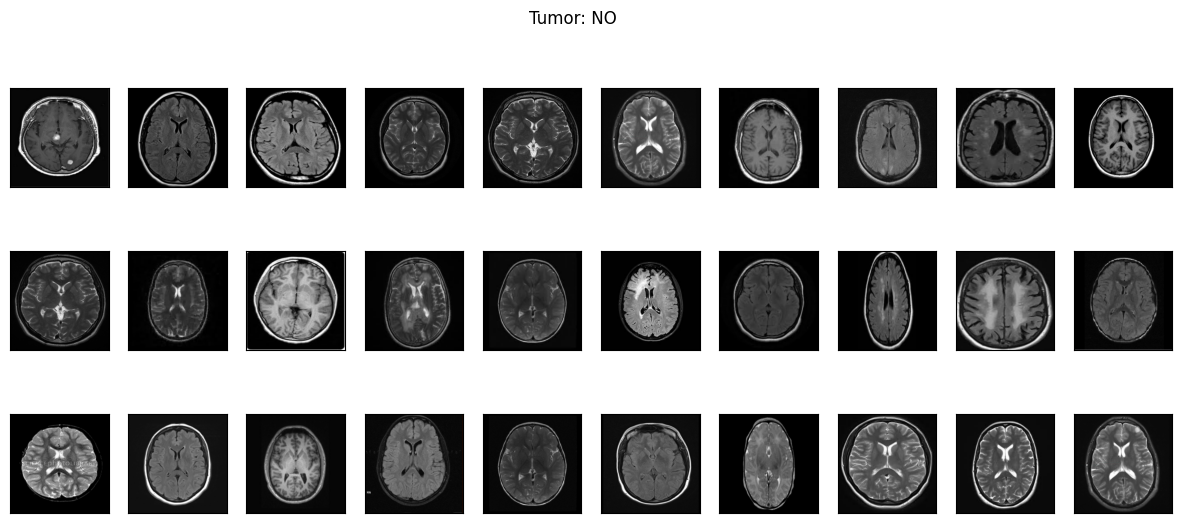

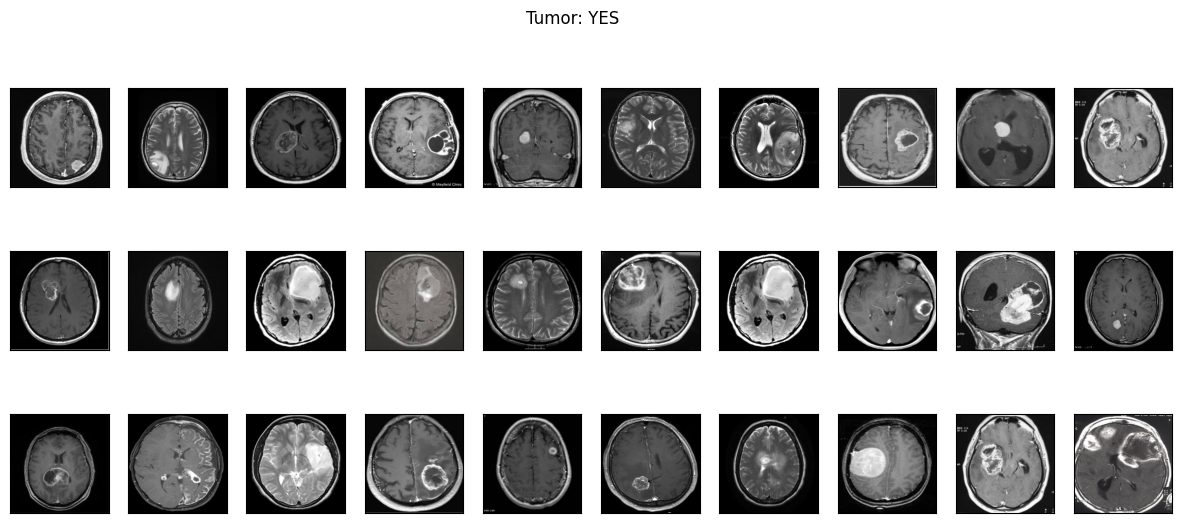

In [50]:
plot_samples(X_train, y_train, labels, 30)

As you can see, images have different `width` and `height` and diffent size of "black corners". Since the image size for VGG-16 imput layer is `(224,224)` some wide images may look weird after resizing. Histogram of ratio distributions (`ratio = width/height`):

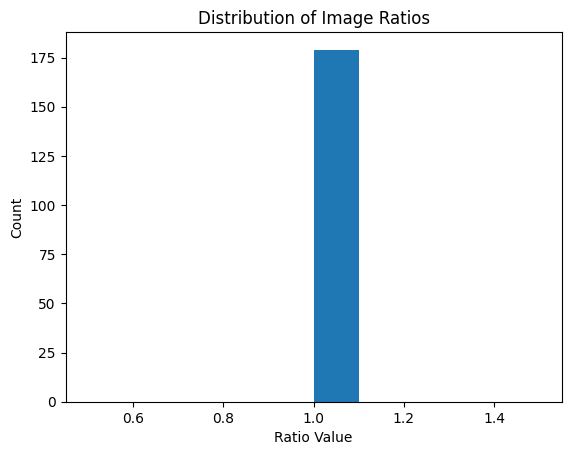

In [51]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])

plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

The first step of "normalization" would be to crop the brain out of the images. I used technique which was perfectly described in [pyimagesearch](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog and I highly suggest to looks deeper into it.

In [52]:
import cv2
import numpy as np
import imutils

def crop_imgs(set_name, add_pixels_value=0, target_size=(224, 224)):
    """
    Finds the extreme points on the image and crops the rectangular out of them.
    Resizes the cropped image to `target_size` to maintain uniformity.
    """
    set_new = []

    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # Threshold the image, then perform a series of erosions/dilations to remove noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Find contours
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        if len(cnts) == 0:  # If no contours are found, append original resized image
            set_new.append(cv2.resize(img, target_size))
            continue

        # Find the largest contour
        c = max(cnts, key=cv2.contourArea)

        # Get extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # Ensure indices are within bounds
        H, W, _ = img.shape
        x1 = max(0, extLeft[0] - add_pixels_value)
        x2 = min(W, extRight[0] + add_pixels_value)
        y1 = max(0, extTop[1] - add_pixels_value)
        y2 = min(H, extBot[1] + add_pixels_value)

        # Crop and resize to maintain consistency
        cropped_img = img[y1:y2, x1:x2].copy()
        resized_img = cv2.resize(cropped_img, target_size)

        set_new.append(resized_img)

    return np.array(set_new, dtype=np.uint8)  # Ensure uniform dtype


Let's look at example what this function will do with MRI scans:

In [53]:
img = cv2.imread('data/brain_mri/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

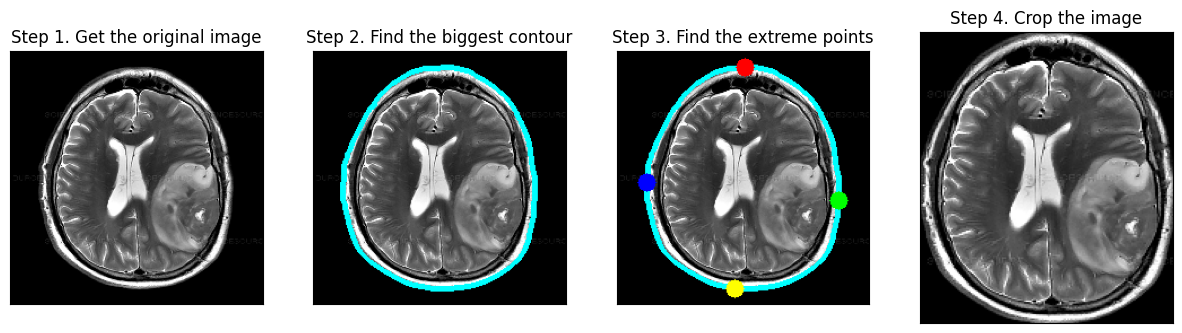

In [54]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [55]:
# apply this for each set
X_train_crop = crop_imgs(X_train, target_size=IMG_SIZE)
X_val_crop = crop_imgs(X_val, target_size=IMG_SIZE)
X_test_crop = crop_imgs(X_test, target_size=IMG_SIZE)


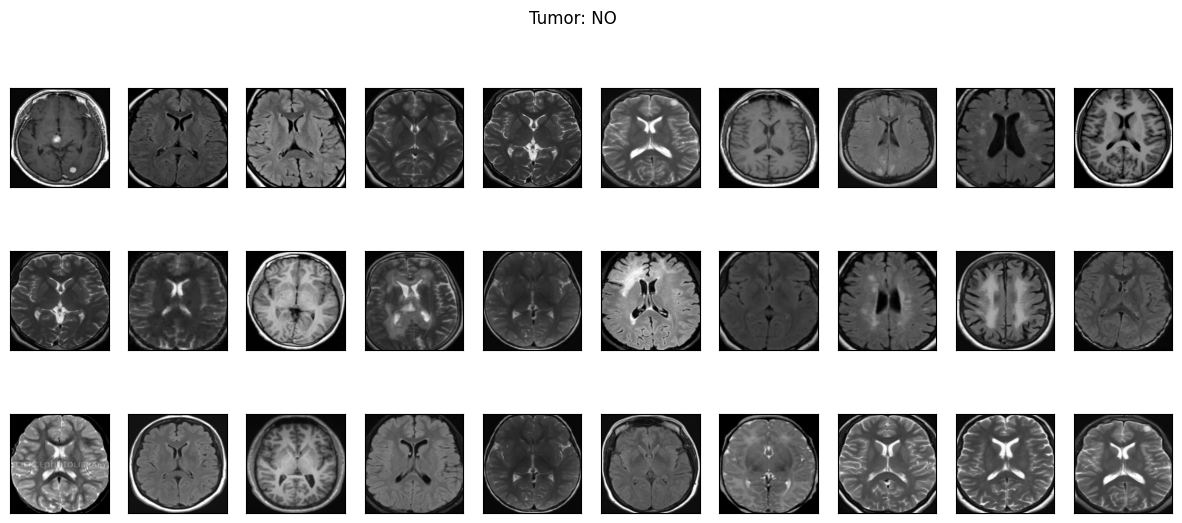

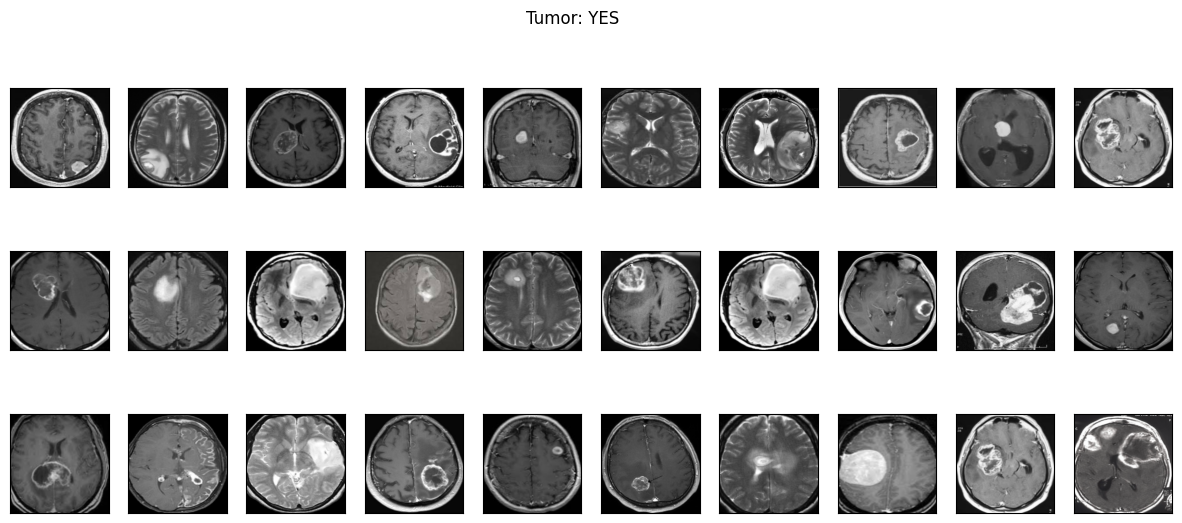

In [56]:
plot_samples(X_train_crop, y_train, labels, 30)

In [57]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [58]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

The next step would be resizing images to `(224,224)` and applying preprocessing needed for VGG-16 model input.

In [59]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [60]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [61]:
# plot_samples(X_train_prep, y_train, labels, 30)

# <a id='cnn'>4. CNN Model</a>

I was using [Transfer Learning](https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e) with VGG-16 architecture and weights as a base model.

## <a id='aug'>4.1. Data Augmentation</a>

Since I had small data set I used the technique called [Data Augmentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) which helps to "increase" the size of training set.

### <a id='demo'>4.1.1. Demo</a>

That's the example from one image how does augmentation look like.

In [62]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [63]:
os.mkdir('preview')
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

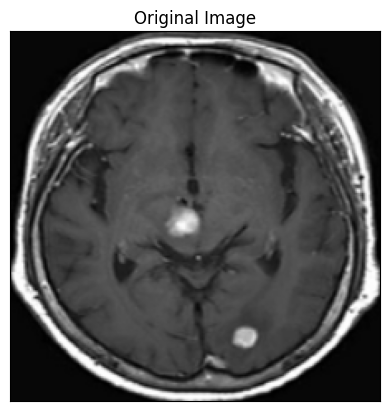

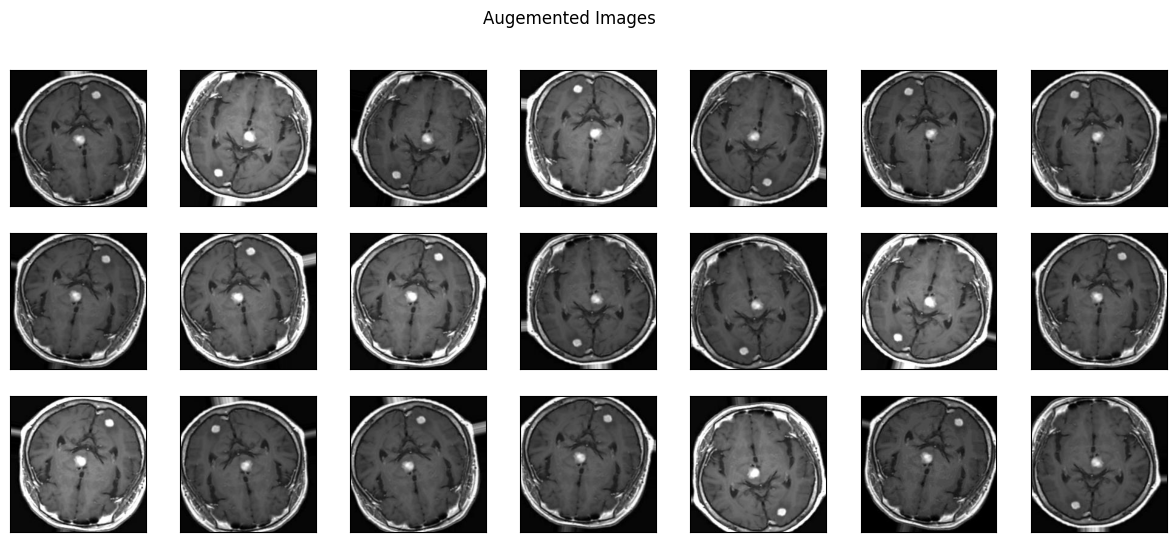

In [64]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [65]:
!rm -rf preview/

### <a id='apply'>4.1.2. Apply</a>

In [66]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 132 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


## <a id='build'>4.2. Model Building</a>

In [67]:
# load base model
vgg16_weight_path = 'data/keras_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

NUM_CLASSES = 1  # Binary Classification

model = Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())  # Better than Flatten()
model.add(layers.Dense(256, activation='relu'))  # Add Dense Layer
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))  # Another Dense Layer
model.add(layers.Dropout(0.3))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))  # Output layer

# Freeze base model for initial training
model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,879,041 (56.76 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [106]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6
)


history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)


Epoch 1/30
 5/50 ━━━━━━━━━━━━━━━━━━━━ 15s 336ms/step - accuracy: 0.7736 - loss: 0.7271

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7455 - loss: 0.8176 - val_accuracy: 0.8947 - val_loss: 0.2921
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7087 - loss: 0.8454 - val_accuracy: 0.8684 - val_loss: 0.3194
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.6973 - loss: 0.8512 - val_accuracy: 0.8947 - val_loss: 0.2968
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7550 - loss: 0.6301 - val_accuracy: 0.8947 - val_loss: 0.2919
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7568 - loss: 0.6177 - val_accuracy: 0.8421 - val_loss: 0.3247
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7158 - loss: 0.7884 - val_accuracy: 0.8684 - val_loss: 0.3070
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7521 - loss: 0.6757 - val_accuracy: 0.9211 - val_loss: 0.2798
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6212 - loss: 0.8790 - val_accuracy: 0.9211 - val_loss: 0.

## <a id='perf'>4.3. Model Performance</a>

In [107]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm, 2)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step 
Val Accuracy = 0.89


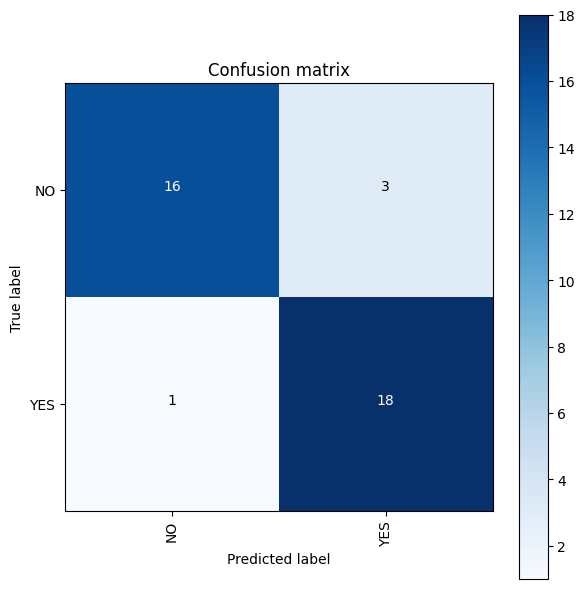

In [108]:
# Validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes=list(labels.values()), normalize=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Test Accuracy = 0.89


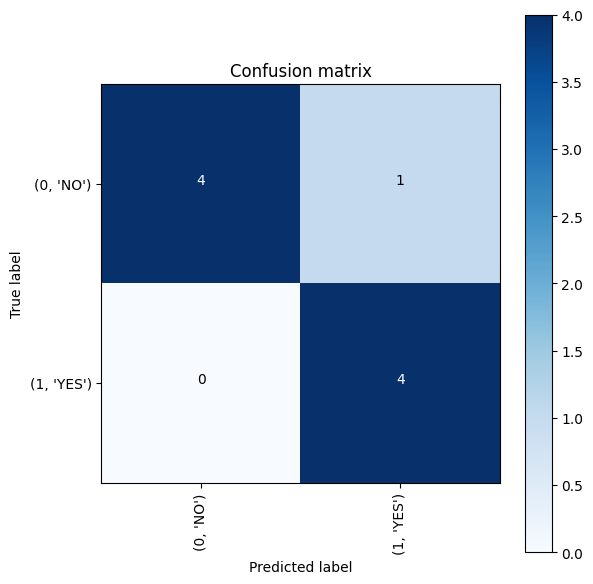

In [109]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Now let's take a look at the images from the `test set` that were misclassified:

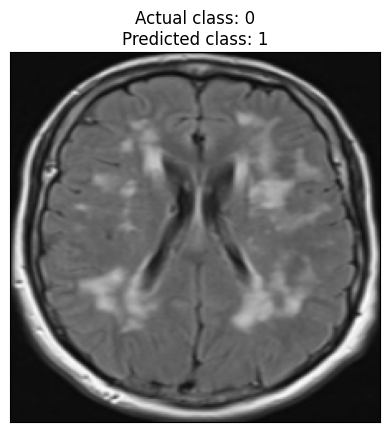

In [110]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

First scan looks a bit misleading - what is that light spot in the middle? 🤔 I can clearly see why model classified it as `Tumor`.

# <a id='concl'>5. Conclusions</a>

This project was a combination of CNN model classification problem (to predict wheter the subject has brain tumor or not) & Computer Vision problem (to automate the process of brain cropping from MRI scans). The final accuracy is much higher than 50% baseline (random guess). However, it could be increased by larger number of train images or through model hyperparameters tuning.

In [111]:
# !rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP

model.save('VGG_model.h5')

In [113]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image

# Load the image
img_path = '/content/data/brain_mri/no/18 no.jpg'  # Change this to your image path
img = image.load_img(img_path, target_size=IMG_SIZE)  # Resize to match model input

# Convert to array
img_array = image.img_to_array(img)

# Preprocess the image
img_array = preprocess_input(img_array)

# Expand dimensions to match model input (batch size of 1)
img_array = np.expand_dims(img_array, axis=0)

# Make a prediction
prediction = model.predict(img_array)[0][0]  # Get the first prediction

# Convert sigmoid output to class label
predicted_label = 1 if prediction > 0.5 else 0

print(f"Prediction: {predicted_label} (Confidence: {prediction:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction: 0 (Confidence: 0.11)
